# QCD estimate from same-sign muon/electron+tau events

It is useful to construct a same-sign region for estimating the background due to multijet QCD in the $\mu+\tau_{h}$ channel.  We estimate this background using the fake rate method so this can be used as a cross-check or a replacement.  This method is used in the measurement of the $\tau_{h}$ efficiencies which I would like to recreate so that the measurement can be carried out _in situ_ and the uncertainty sources are not double counted.

In [50]:
# import and global set up
%cd '/home/naodell/work/wbr/analysis'
%matplotlib notebook
%pwd

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import scripts.plot_tools as pt
pt.set_default_style()

%matplotlib inline

/home/naodell/work/wbr/analysis


In [51]:
# get the data
# set up and get the data
selection = 'etau'
if selection == 'mutau':
    labels = ['muon']
elif selection == 'etau':
    labels = ['electron']
labels += ['t', 'ttbar', 'wjets', 'zjets_alt', 'diboson']

dm = pt.DataManager(input_dir     = f'local_data/flatuples/test/{selection}_2016',
                    dataset_names = [d for l in labels for d in pt.dataset_dict[l]],
                    selection     = selection,
                    period        = 2016,
                    scale         = 35.9e3,
                    cuts          = ''#n_bjets == 0  and n_jets < 2'
                                     #and p_miss_zeta - 0.85*p_vis_zeta > -25 \
                                     #and 40 < dilepton1_mass < 100'
                                     #and lepton1_mt < 40 \
                   )
df_data_os  = dm.get_dataframe('data').query('lepton1_q != lepton2_q')
df_ttbar_os = dm.get_dataframe('ttbar').query('lepton1_q != lepton2_q')
df_top_os   = dm.get_dataframe('t').query('lepton1_q != lepton2_q')
df_z_os     = dm.get_dataframe('zjets_alt').query('lepton1_q != lepton2_q')
df_w_os     = dm.get_dataframe('wjets').query('lepton1_q != lepton2_q')
df_vv_os    = dm.get_dataframe('diboson').query('lepton1_q != lepton2_q')

df_data_ss  = dm.get_dataframe('data').query('lepton1_q == lepton2_q').copy()
df_ttbar_ss = dm.get_dataframe('ttbar').query('lepton1_q == lepton2_q').copy()
df_top_ss   = dm.get_dataframe('t').query('lepton1_q == lepton2_q').copy()
df_z_ss     = dm.get_dataframe('zjets_alt').query('lepton1_q == lepton2_q').copy()
df_w_ss     = dm.get_dataframe('wjets').query('lepton1_q == lepton2_q').copy()
df_vv_ss    = dm.get_dataframe('diboson').query('lepton1_q == lepton2_q').copy()

Loading dataframes: 100%|███████████████| 20.0/20.0 [00:09<00:00, 2.11it/s]


/home/naodell/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


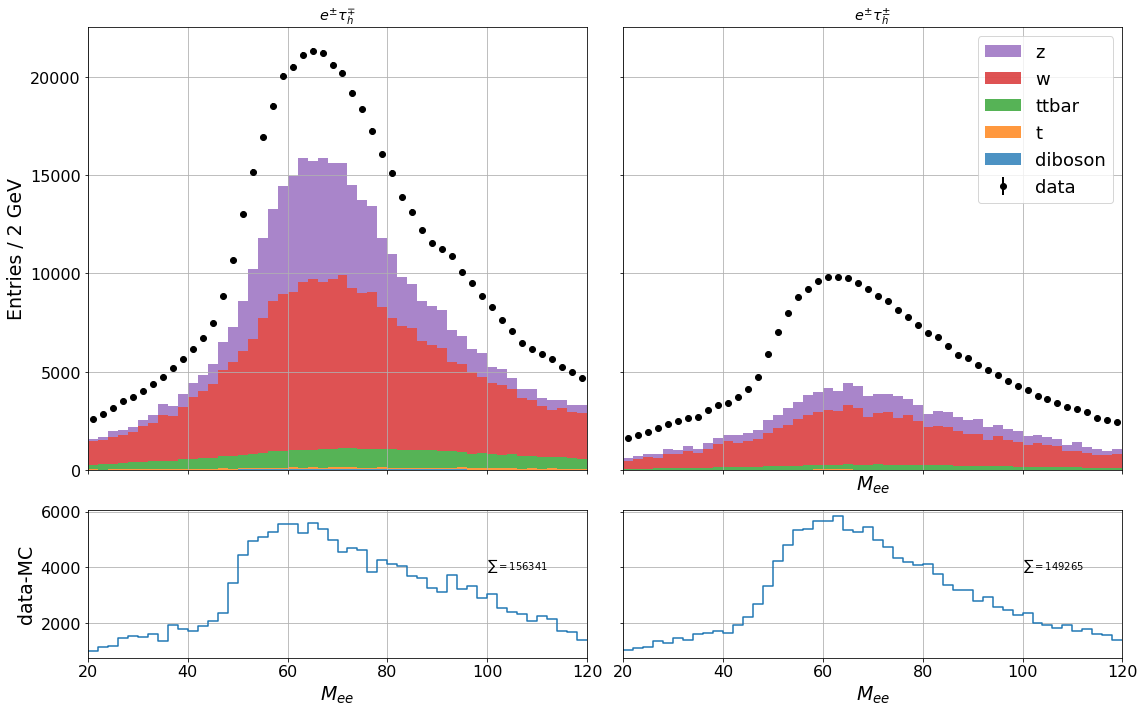

In [52]:
# compare the OS and SS control regions
fig, axes = plt.subplots(2, 2, figsize=(16, 10), facecolor='white', gridspec_kw={'height_ratios':[3,1]}, sharex='col', sharey='row')
fig.subplots_adjust(hspace=0)

var = 'dilepton1_mass'
bins = np.arange(20, 122, 2)

ax = axes[0][0]
x, y, yerr = pt.hist_to_errorbar(df_data_os[var], bins = bins)
ax.errorbar(x, y, yerr, fmt='ko', capsize=0, elinewidth=2)
h_mc, _, _ = ax.hist([df_vv_os[var], df_top_os[var], df_ttbar_os[var], df_w_os[var], df_z_os[var]], 
                     bins=bins, 
                     histtype='stepfilled', 
                     alpha=0.8, 
                     weights=[df_vv_os['weight'], df_top_os['weight'], df_ttbar_os['weight'], df_w_os['weight'], df_z_os['weight']], 
                     stacked=True)
ax.grid()
ax.set_ylabel('Entries / 2 GeV')
ax.set_xlim(bins.min(), bins.max())
if selection == 'mutau':
    ax.set_title(r'$\mu^{\pm}\tau^{\mp}_{h}$')
elif selection == 'etau':
    ax.set_title(r'$e^{\pm}\tau^{\mp}_{h}$')
    

ax = axes[1][0]
h_data, _ = np.histogram(df_data_os[var], bins=bins)
diff = y - h_mc[-1]
diff_os = np.append(diff, diff[-1])
ax.plot(bins, diff_os, drawstyle='steps-post')
ax.text(0.8, 0.6, r'$\sum =$' + f'{diff.sum():.0f}', transform = ax.transAxes)
ax.set_ylabel('data-MC')
ax.grid()

if selection == 'mutau':
    ax.set_xlabel('$M_{\mu\mu}$')
elif selection == 'etau':
    ax.set_xlabel('$M_{ee}$')

ax = axes[0][1]
x, y, yerr = pt.hist_to_errorbar(df_data_ss[var], bins = bins)
eb = ax.errorbar(x, y, yerr, fmt='ko', capsize=0, elinewidth=2)
h_mc, _, _ = ax.hist([df_vv_ss[var], df_top_ss[var], df_ttbar_ss[var], df_w_ss[var], df_z_ss[var]], 
                     bins=bins, 
                     histtype='stepfilled', 
                     alpha=0.8, 
                     weights=[df_vv_ss['weight'], df_top_ss['weight'], df_ttbar_ss['weight'], df_w_ss['weight'], df_z_ss['weight']], 
                     stacked=True
                    )
ax.grid()
ax.set_xlim(bins.min(), bins.max())
ax.legend(['z', 'w', 'ttbar', 't', 'diboson', 'data'])
if selection == 'mutau':
    ax.set_title(r'$\mu^{\pm}\tau^{\pm}_{h}$')
    ax.set_xlabel('$M_{\mu\mu}$')
elif selection == 'etau':
    ax.set_title(r'$e^{\pm}\tau^{\pm}_{h}$')
    ax.set_xlabel('$M_{ee}$')

ax = axes[1][1]
diff = y - h_mc[-1]
diff_ss = np.append(diff, diff[-1])
ax.plot(bins, diff_ss, drawstyle='steps-post')
ax.text(0.8, 0.6, r'$\sum =$' + f'{diff.sum():.0f}', transform = ax.transAxes)
ax.grid()

if selection == 'mutau':
    ax.set_xlabel('$M_{\mu\mu}$')
elif selection == 'etau':
    ax.set_xlabel('$M_{ee}$')

plt.tight_layout()
plt.savefig(f'plots/{selection}_cr.pdf')
plt.show()

### Calculating the fake background

The mapping from the same-sign control region to the same-sign signal region is done as follows,

$$
N_{OS} = k(N_{SS,data} - N_{SS,bkg})
$$

where $k$ is some scale factor for normalizing the SS data to OS.  The processes that are take from simulation are subtracted from the SS region to avoid double counting.

In [53]:
# N.B.: RUNNING THIS PANEL REPEATEDLY WITHOUT RELOADING THE DATA WILL FUCK SHIT UP YO
# first multiply the weights for the simulated processes by -1
df_ttbar_ss.loc[:,'weight'] *= -1  
df_top_ss.loc[:,'weight'] *= -1  
df_z_ss.loc[:,'weight'] *= -1    
df_w_ss.loc[:,'weight'] *= -1    
df_vv_ss.loc[:,'weight'] *= -1    

# multiply by k and combine the same-sign data and MC (this should be calculated from the isolation inverted control region)
k = diff_os.sum()/diff_ss.sum()
df_qcd = pd.concat([df_data_ss, df_w_ss, df_ttbar_ss, df_top_ss, df_z_ss, df_vv_ss])
df_qcd.loc[:,'weight'] *= k

# relabel fakes
df_qcd['label'] = 'fakes'

/home/naodell/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)
/home/naodell/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


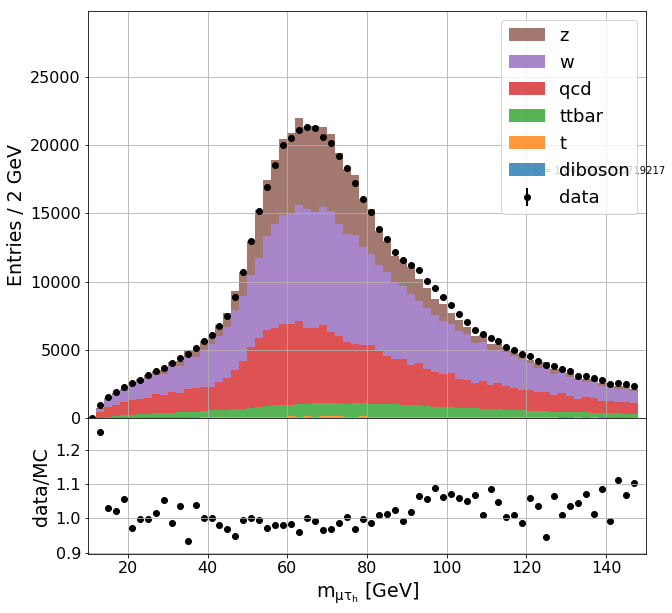

In [54]:
# test the QCD estimate
fig, axes = plt.subplots(2, 1, figsize=(10, 10), facecolor='white', gridspec_kw={'height_ratios':[3,1]}, sharex=True)
fig.subplots_adjust(hspace=0)

var = 'dilepton1_mass'
bins = np.arange(10, 150, 2)

ax = axes[0]
x, y, yerr = pt.hist_to_errorbar(df_data_os[var], bins=bins)
eb = ax.errorbar(x, y, yerr, fmt='ko', capsize=0, elinewidth=2)
h_mc, _, _ = ax.hist([df_vv_os[var], df_top_os[var], df_ttbar_os[var], df_qcd[var], df_w_os[var], df_z_os[var]], 
                     bins=bins,
                     histtype='stepfilled', 
                     alpha=0.8, 
                     stacked=True,
                     weights=[df_vv_os['weight'], df_top_os['weight'], df_ttbar_os['weight'], df_qcd['weight'], df_w_os['weight'], df_z_os['weight']])

ax.legend(['z', 'w', 'qcd', 'ttbar', 't', 'diboson', 'data'])
ax.text(0.8, 0.6, f'k = {k}', transform = ax.transAxes)
ax.grid()
ax.set_ylim(0, 1.4*y.max())
ax.set_ylabel(f'Entries / {(bin_range[1]-bin_range[0])/nbins:.0f} GeV')
ax.set_yscale('linear')

ax = axes[1]
r = y/h_mc[-1]
ax.scatter(x, r, marker='o', c='k')
ax.grid()
ax.set_xlim(bin_range)
#ax.set_ylim(0.75, 1.49)
#ax.set_xlabel(r'$\sf p_{T,\tau_{h}}$ [GeV]')
ax.set_xlabel(r'$\sf m_{\mu\tau_{h}}$ [GeV]')
ax.set_ylabel('data/MC')

plt.savefig(f'plots/{selection}_{var}.pdf')
plt.show()

## correction factor from isolation inverted region

In [55]:
if selection == 'mutau':
     datasets = [
                 'muon_2016B_fakes', 'muon_2016C_fakes', 'muon_2016D_fakes',
                 'muon_2016E_fakes', 'muon_2016F_fakes', 'muon_2016G_fakes',
                 'muon_2016H_fakes'
                ]
elif selection == 'etau':
     datasets = [
                 'electron_2016B_fakes', 'electron_2016C_fakes', 'electron_2016D_fakes',
                 'electron_2016E_fakes', 'electron_2016F_fakes', 'electron_2016G_fakes',
                 'electron_2016H_fakes'
                ]
dm = pt.DataManager(input_dir     = f'local_data/flatuples/test/{selection}_2016',
                    dataset_names = datasets,
                    selection     = selection,
                    period        = 2016,
                    scale         = 35.9e3,
                    cuts          = ''#n_bjets == 0  and n_jets < 2'
                                     #and p_miss_zeta - 0.85*p_vis_zeta > -25 \
                                     #and 40 < dilepton1_mass < 100'
                                     #and lepton1_mt < 40 \
                   )

Loading dataframes: 100%|███████████████| 7.00/7.00 [00:03<00:00, 1.87it/s]


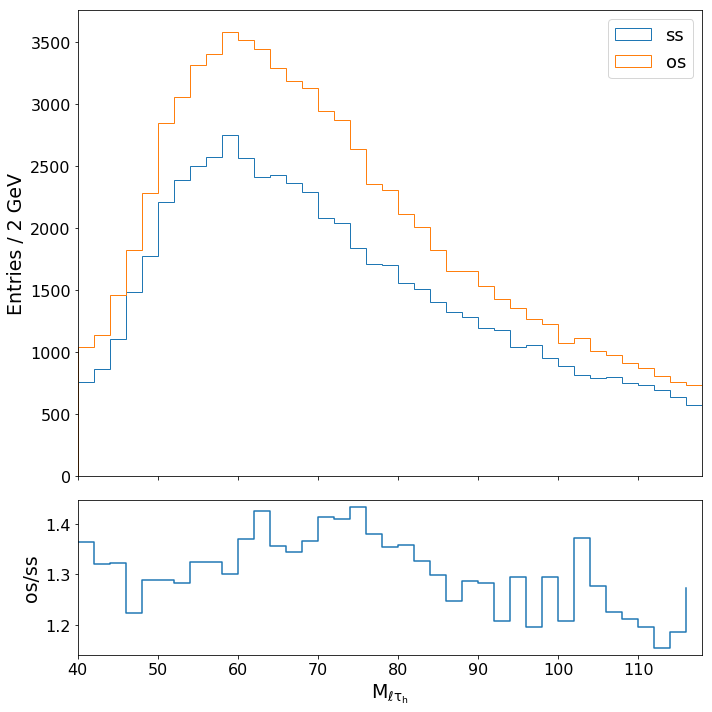

In [61]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10), facecolor='white', gridspec_kw={'height_ratios':[3,1]}, sharex=True)
fig.subplots_adjust(hspace=0)

ax = axes[0]
df_fakes = dm.get_dataframe('fakes')
bins = np.arange(40, 120, 2)
h_ss, _, _ = ax.hist(df_fakes.query('lepton1_q == lepton2_q')['dilepton1_mass'], label = 'ss', histtype='step', bins = bins)
h_os, _, _ = ax.hist(df_fakes.query('lepton1_q != lepton2_q')['dilepton1_mass'], label = 'os', histtype='step', bins = bins)
ax.set_xlim(bins[0], bins[-1])
ax.set_ylabel('Entries / 2 GeV')
ax.legend()

ax = axes[1]
ax.plot(bins[:-1], h_os/h_ss, drawstyle='steps-post')
ax.set_ylabel('os/ss')
ax.set_xlabel(r'$\sf M_{\ell\tau_{h}}$')

plt.tight_layout()
plt.show()